In [1]:
# ============================================================
# 📘 Document Type Classification - EDA Notebook
# ============================================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import matplotlib.font_manager as fm

# 리눅스 서버에서 한글 폰트 설치 (최초 1회만 실행 필요) -> 설치 완! 
# !apt-get install -y fonts-nanum > /dev/null 2>&1

# NanumGothic 폰트 등록
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
if os.path.exists(font_path):
    fm.fontManager.addfont(font_path)
    plt.rcParams['font.family'] = 'NanumGothic'
else:
    plt.rcParams['font.family'] = 'DejaVu Sans'  # fallback
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# ============================================================
# 1️⃣ 데이터 불러오기
# ============================================================
# train_df = pd.read_csv("../data/train.csv")
train_df = pd.read_csv("../data/train_mod.csv")
test_df = pd.read_csv("../data/sample_submission.csv")

print("✅ Train shape:", train_df.shape)
print("✅ Test shape:", test_df.shape)
print("\n📋 Train head:")
display(train_df.head())

✅ Train shape: (1570, 2)
✅ Test shape: (3140, 2)

📋 Train head:


ID  target
0  002f99746285dfdd.jpg      16
1  008ccd231e1fea5d.jpg      10
2  008f5911bfda7695.jpg      10
3  009235e4c9c07af5.jpg       4
4  00b2f44967580c74.jpg      16

/tmp/ipykernel_1048550/3916694296.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=train_df, palette='tab20')


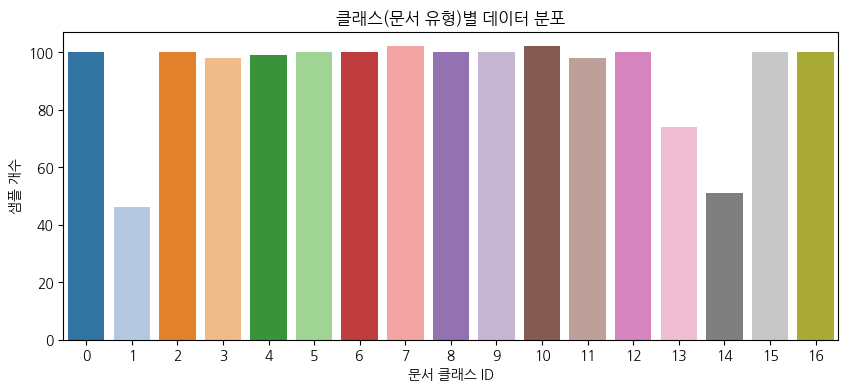

클래스별 데이터 개수:
target
0     100
1      46
2     100
3      98
4      99
5     100
6     100
7     102
8     100
9     100
10    102
11     98
12    100
13     74
14     51
15    100
16    100
Name: count, dtype: int64
클래스별 비율(%)


target
0     6.369427
1     2.929936
2     6.369427
3     6.242038
4     6.305732
5     6.369427
6     6.369427
7     6.496815
8     6.369427
9     6.369427
10    6.496815
11    6.242038
12    6.369427
13    4.713376
14    3.248408
15    6.369427
16    6.369427
Name: proportion, dtype: float64

In [3]:
# ============================================================
# 2️⃣ 클래스 분포 확인
# ============================================================
plt.figure(figsize=(10,4))
sns.countplot(x='target', data=train_df, palette='tab20')
plt.title("클래스(문서 유형)별 데이터 분포")
plt.xlabel("문서 클래스 ID")
plt.ylabel("샘플 개수")
plt.show()

# 클래스별 데이터 개수 확인 (특히 1, 13, 14)
class_counts = train_df['target'].value_counts().sort_index()
print("클래스별 데이터 개수:")
print(class_counts)

# 각 클래스별 비율도 출력
class_ratio = train_df['target'].value_counts(normalize=True).sort_index() * 100
print("클래스별 비율(%)")
display(class_ratio)


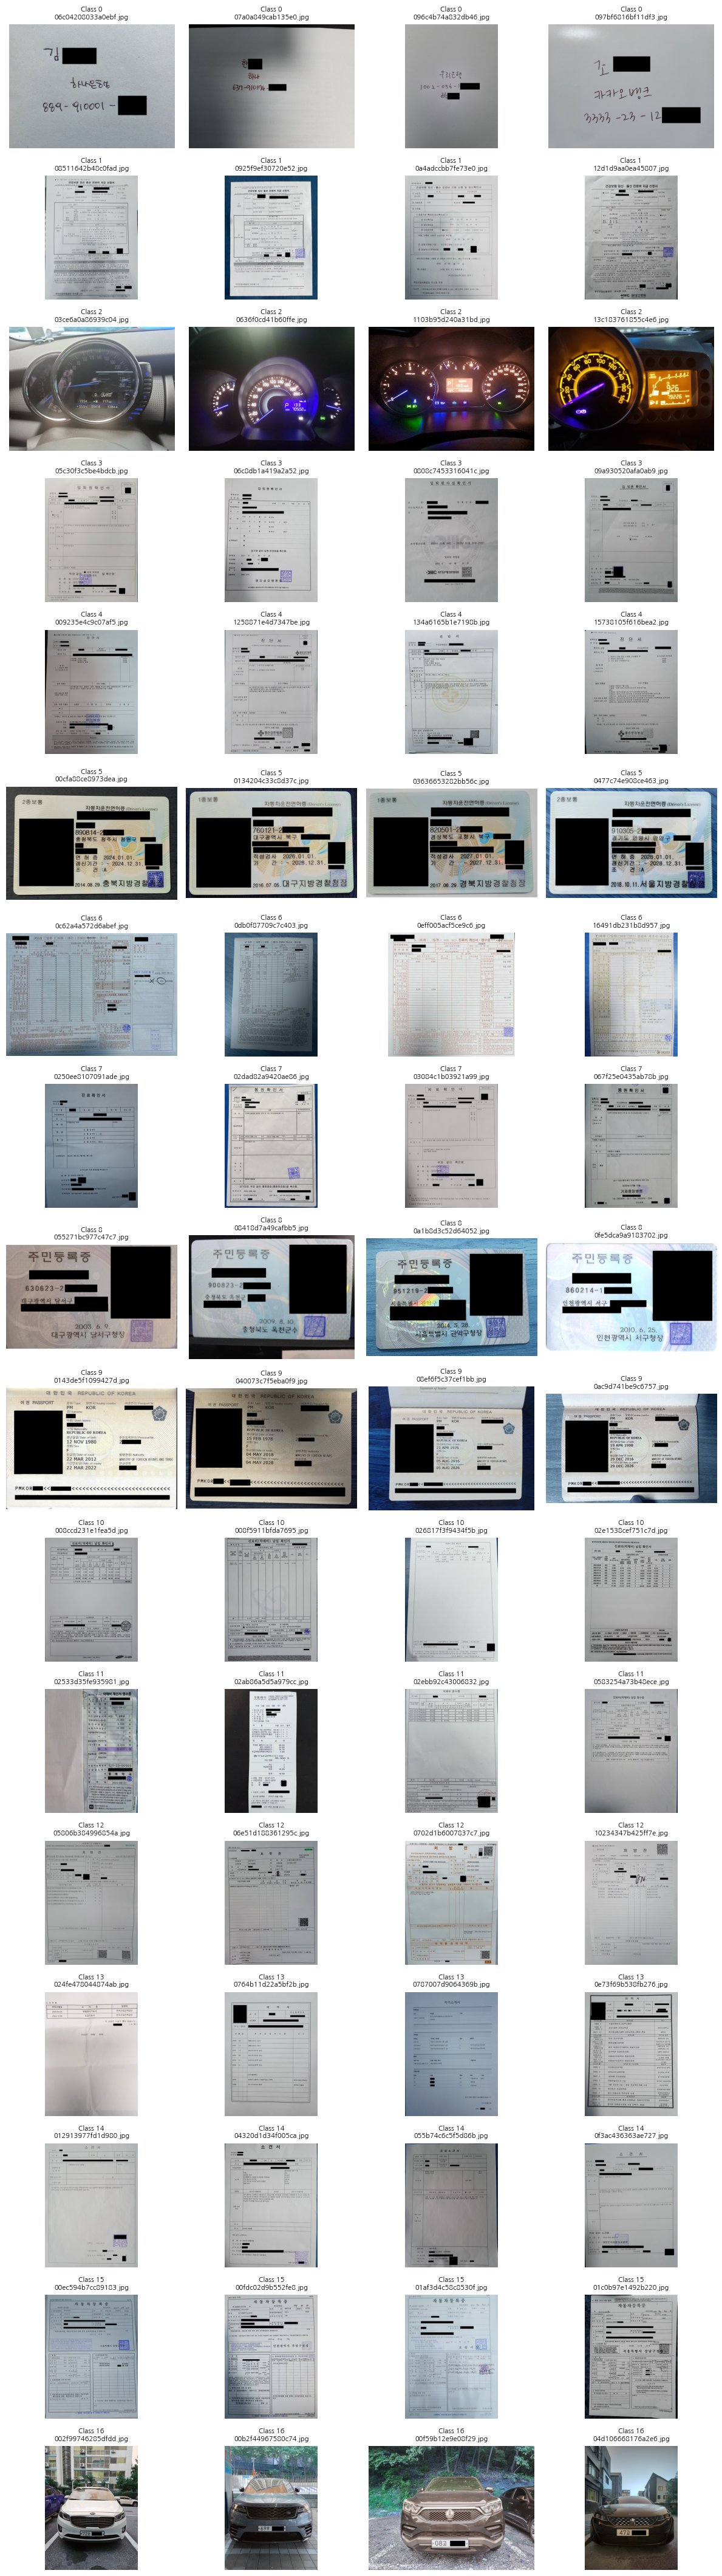

==== 진행 현황 (이번 실행) ====
클래스  0 | 이번에 표시:  4 | 전체: 100 | 남은:  96
클래스  1 | 이번에 표시:  4 | 전체:  46 | 남은:  42
클래스  2 | 이번에 표시:  4 | 전체: 100 | 남은:  96
클래스  3 | 이번에 표시:  4 | 전체: 100 | 남은:  96
클래스  4 | 이번에 표시:  4 | 전체: 100 | 남은:  96
클래스  5 | 이번에 표시:  4 | 전체: 100 | 남은:  96
클래스  6 | 이번에 표시:  4 | 전체: 100 | 남은:  96
클래스  7 | 이번에 표시:  4 | 전체: 100 | 남은:  96
클래스  8 | 이번에 표시:  4 | 전체: 100 | 남은:  96
클래스  9 | 이번에 표시:  4 | 전체: 100 | 남은:  96
클래스 10 | 이번에 표시:  4 | 전체: 100 | 남은:  96
클래스 11 | 이번에 표시:  4 | 전체: 100 | 남은:  96
클래스 12 | 이번에 표시:  4 | 전체: 100 | 남은:  96
클래스 13 | 이번에 표시:  4 | 전체:  74 | 남은:  70
클래스 14 | 이번에 표시:  4 | 전체:  50 | 남은:  46
클래스 15 | 이번에 표시:  4 | 전체: 100 | 남은:  96
클래스 16 | 이번에 표시:  4 | 전체: 100 | 남은:  96

※ 다시 실행하면 다음 4장이 표시됩니다. 모두 소비되면 해당 클래스는 더 이상 증가하지 않습니다.


In [4]:
# ============================================================
# 🔹 클래스별 ‘순차·무중복’ 배치 시각화 (클래스 오름차순, 4장씩, 파일명 표시)
# ============================================================
import json
from PIL import Image

train_img_dir = "../data/train/"
name_col, label_col = "ID", "target"
BATCH_N = 4                       # ✅ 클래스당 4장씩 보기
PROGRESS_PATH = "./eda_progress.json"

# 1) 진행상태 로드 (없으면 0으로 초기화)
if os.path.exists(PROGRESS_PATH):
    with open(PROGRESS_PATH, "r") as f:
        progress = json.load(f)
else:
    progress = {}

# 2) 클래스별 인덱스 수집 (CSV 순서 그대로)
class_indices = {}
for c in sorted(train_df[label_col].unique()):
    cls_idx = train_df.index[train_df[label_col] == c].tolist()
    class_indices[c] = cls_idx
    progress.setdefault(str(c), 0)

# 3) 이번 실행에 표시할 샘플 뽑기
picked_rows = []
summary = []
for c in sorted(class_indices.keys()):
    start = progress[str(c)]
    cls_idx = class_indices[c]
    end = min(start + BATCH_N, len(cls_idx))
    picked_idx = cls_idx[start:end]

    picked_rows.extend(
        train_df.loc[picked_idx, [name_col, label_col]].assign(_class=c).to_dict("records")
    )

    summary.append((c, len(picked_idx), len(cls_idx), len(cls_idx) - end))
    progress[str(c)] = end

# 4) 진행상태 저장
with open(PROGRESS_PATH, "w") as f:
    json.dump(progress, f)

# 5) 시각화 (행: 클래스, 열: BATCH_N)
import math
n_classes = len(sorted(class_indices.keys()))
rows, cols = n_classes, BATCH_N
plt.figure(figsize=(cols * 3, rows * 2.5))  # ✅ 각 이미지를 더 크게

row_map = {c: i for i, c in enumerate(sorted(class_indices.keys()))}
for_class_counter = {c: 0 for c in sorted(class_indices.keys())}

for rec in picked_rows:
    c = rec["_class"]
    k = for_class_counter[c]
    for_class_counter[c] += 1
    if k >= cols:
        continue

    img_path = os.path.join(train_img_dir, rec[name_col])
    try:
        img = Image.open(img_path)
    except Exception:
        img = Image.new("RGB", (224, 224), (200, 200, 200))

    ax = plt.subplot(rows, cols, row_map[c] * cols + k + 1)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f"Class {c}\n{rec[name_col]}", fontsize=8)  # ✅ 파일명 표시

plt.tight_layout()
plt.show()

# 6) 진행 현황 출력
print("==== 진행 현황 (이번 실행) ====")
for c, shown_now, total, remaining in summary:
    print(f"클래스 {c:>2} | 이번에 표시: {shown_now:>2} | 전체: {total:>3} | 남은: {remaining:>3}")

print("\n※ 다시 실행하면 다음 4장이 표시됩니다. "
      "모두 소비되면 해당 클래스는 더 이상 증가하지 않습니다.")

# (선택) 진행상태 초기화 유틸
def reset_eda_progress(path=PROGRESS_PATH):
    if os.path.exists(path):
        os.remove(path)
        print("EDA 진행상태를 초기화했습니다.")
    else:
        print("초기화할 진행상태 파일이 없습니다.")


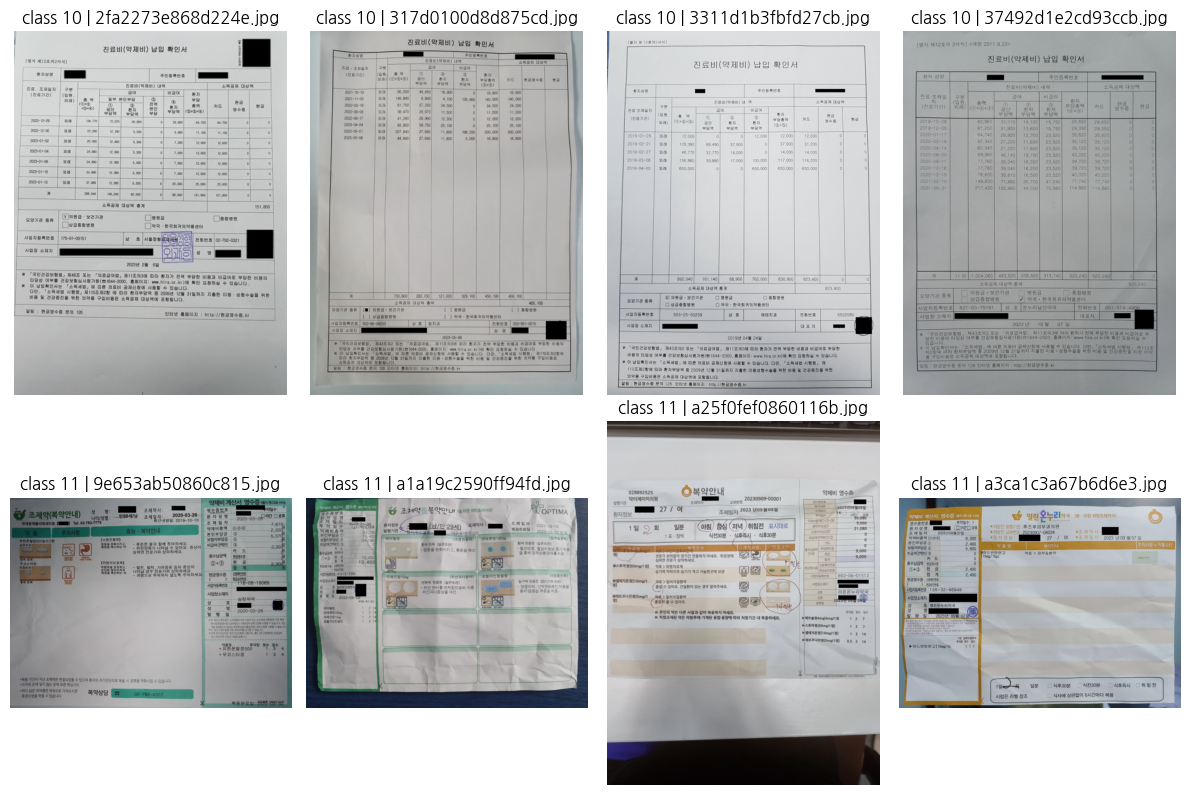

In [81]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import time
import numpy as np

# ============================================================
# 🔹 클래스 10 vs 11 비교 시각화 (오름차순 + 실행마다 다른 묶음)
# ============================================================
compare_classes = [10, 11]
n_samples = 4  # 클래스당 몇 개씩 볼지
plt.figure(figsize=(12, 4 * len(compare_classes)))

# ✅ 시드 고정 대신 실행마다 변하도록 설정
seed = int(time.time()) % 10000  # 매번 시간 기반으로 시드 바뀜
np.random.seed(seed)

for idx, c in enumerate(compare_classes):
    # --- 클래스별 이미지 목록 오름차순 정렬
    c_imgs = sorted(train_df[train_df['target'] == c]['ID'].tolist())

    # --- 시작 위치를 랜덤으로 선택하되, 넘치지 않게 조정
    if len(c_imgs) > n_samples:
        start_idx = np.random.randint(0, len(c_imgs) - n_samples + 1)
    else:
        start_idx = 0

    # --- 선택된 구간의 연속된 이미지 표시
    selected_imgs = c_imgs[start_idx:start_idx + n_samples]

    for i, img_name in enumerate(selected_imgs):
        img = Image.open(os.path.join(train_img_dir, img_name))
        plt.subplot(len(compare_classes), n_samples, idx * n_samples + i + 1)
        plt.imshow(img)
        plt.title(f"class {c} | {img_name}")
        plt.axis('off')

plt.tight_layout()
plt.show()


100%|██████████| 500/500 [00:00<00:00, 17082.24it/s]


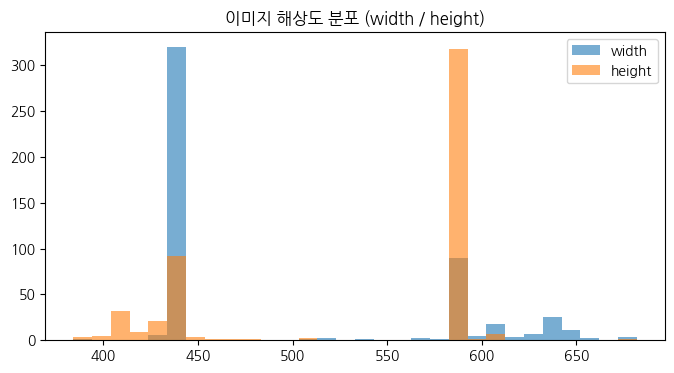

평균 해상도: 499.1 x 536.7


In [24]:
# ============================================================
# 3️⃣ 이미지 크기(해상도) 통계
# ============================================================
train_img_dir = "../data/train/"
img_paths = [os.path.join(train_img_dir, name) for name in train_df['ID']]

sizes = []
for path in tqdm(img_paths[:500]):  # 전부 다 하면 느릴 수 있으니 일부만
    with Image.open(path) as img:
        sizes.append(img.size)  # (width, height)

sizes = np.array(sizes)
widths, heights = sizes[:,0], sizes[:,1]

plt.figure(figsize=(8,4))
plt.hist(widths, bins=30, alpha=0.6, label='width')
plt.hist(heights, bins=30, alpha=0.6, label='height')
plt.legend()
plt.title("이미지 해상도 분포 (width / height)")
plt.show()

print(f"평균 해상도: {np.mean(widths):.1f} x {np.mean(heights):.1f}")


findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.


findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Fon

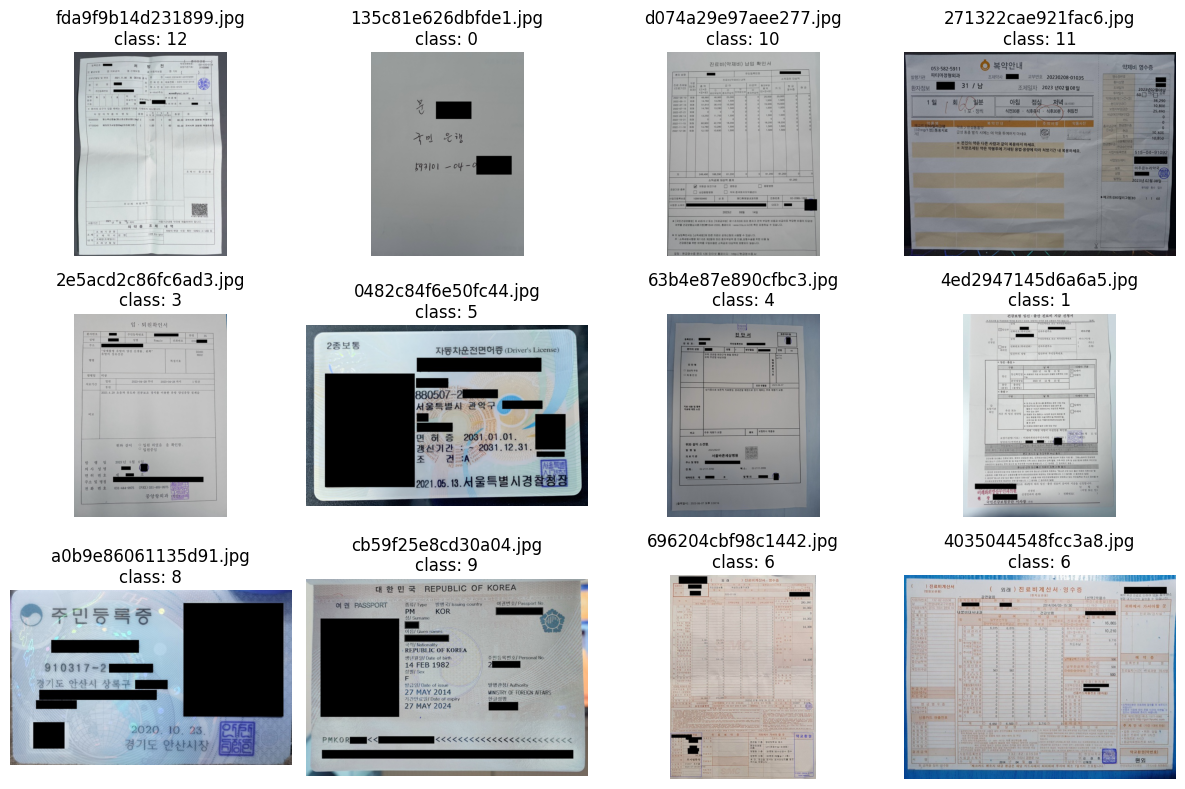

In [13]:
# ============================================================
# 4️⃣ 임의의 샘플 시각화
# ============================================================
import random
n_samples = 12
sample_ids = random.sample(list(train_df['ID']), n_samples)

plt.figure(figsize=(12,8))
for i, img_name in enumerate(sample_ids):
    img_path = os.path.join(train_img_dir, img_name)
    img = Image.open(img_path)
    plt.subplot(3,4,i+1)
    plt.imshow(img)
    plt.title(f"{img_name}\nclass: {train_df.loc[train_df['ID']==img_name, 'target'].values[0]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [14]:
# ============================================================
# 5️⃣ 색상(그레이스케일/컬러) 비율 파악
# ============================================================
gray_count = 0
rgb_count = 0

for path in tqdm(img_paths[:500]):
    with Image.open(path) as img:
        mode = img.mode  # 'RGB', 'L', 'RGBA' 등
        if mode == 'RGB':
            rgb_count += 1
        else:
            gray_count += 1

print(f"RGB 이미지: {rgb_count},  Grayscale/RGBA 이미지: {gray_count}")


100%|██████████| 500/500 [00:00<00:00, 19070.22it/s]

RGB 이미지: 500,  Grayscale/RGBA 이미지: 0


findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Fon

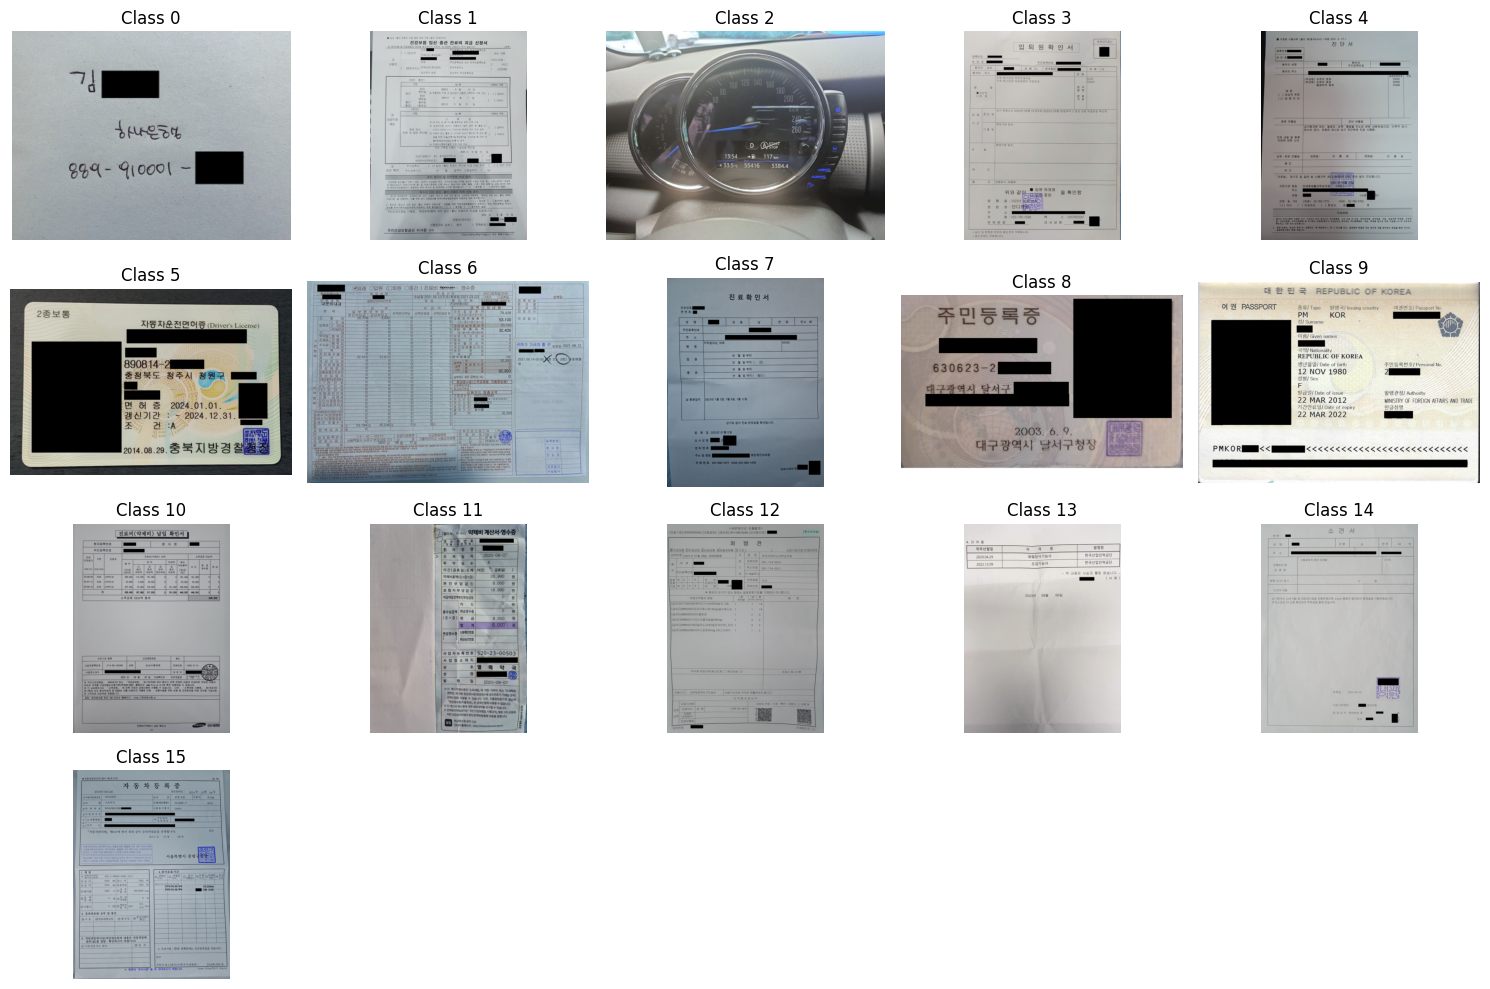

In [15]:
# ============================================================
# 6️⃣ 클래스별 샘플 이미지 보기 (각 클래스 대표 1개)
# ============================================================
unique_labels = sorted(train_df['target'].unique())

plt.figure(figsize=(15, 10))
for i, label in enumerate(unique_labels[:16]):  # 17개면 한 줄 더 늘리기
    sample_name = train_df[train_df['target'] == label]['ID'].iloc[0]
    img_path = os.path.join(train_img_dir, sample_name)
    img = Image.open(img_path)
    plt.subplot(4,5,i+1)
    plt.imshow(img)
    plt.title(f"Class {label}")
    plt.axis('off')
plt.tight_layout()
plt.show()
